# 한국어 뉴스 토픽

In [1]:
# 폰트
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (7,037 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 156210 files and d

In [1]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

## 1.데이터 탐색

In [2]:
!pip install transformers

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.train import latest_checkpoint
import re
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 
import os
import seaborn as sns

In [4]:
# 학습, 예측 데이터셋을 불러옵니다
# train, test
DATA_PATH = '/content/drive/MyDrive/files/news/'
train = pd.read_csv(DATA_PATH + "kor/train_data.csv")
topic = pd.read_csv(DATA_PATH + "kor/topic_dict.csv")
test = pd.read_csv(DATA_PATH + "kor/test_data.csv")
train.shape, test.shape

((45654, 3), (9131, 2))

In [5]:
train.head()

,index,title,topic_idx
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4


In [6]:
test.head()

,index,title
0,45654,유튜브 내달 2일까지 크리에이터 지원 공간 운영
1,45655,어버이날 맑다가 흐려져…남부지방 옅은 황사
2,45656,내년부터 국가RD 평가 때 논문건수는 반영 않는다
3,45657,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것
4,45658,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간


In [7]:
# 토픽을 불러온다
topic = pd.read_csv(DATA_PATH + "kor/topic_dict.csv")
topic

,topic,topic_idx
0,IT과학,0
1,경제,1
2,사회,2
3,생활문화,3
4,세계,4
5,스포츠,5
6,정치,6


In [8]:
train.head()

,index,title,topic_idx
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4


In [9]:
topic.head()

,topic,topic_idx
0,IT과학,0
1,경제,1
2,사회,2
3,생활문화,3
4,세계,4


In [10]:
test.head()

,index,title
0,45654,유튜브 내달 2일까지 크리에이터 지원 공간 운영
1,45655,어버이날 맑다가 흐려져…남부지방 옅은 황사
2,45656,내년부터 국가RD 평가 때 논문건수는 반영 않는다
3,45657,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것
4,45658,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45654 entries, 0 to 45653
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   index      45654 non-null  int64 
 1   title      45654 non-null  object
 2   topic_idx  45654 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.0+ MB


In [12]:
train.isnull().sum()

index        0
title        0
topic_idx    0
dtype: int64

In [13]:
topic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   topic      7 non-null      object
 1   topic_idx  7 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 240.0+ bytes


In [14]:
topic.to_numpy()

array([['IT과학', 0],
       ['경제', 1],
       ['사회', 2],
       ['생활문화', 3],
       ['세계', 4],
       ['스포츠', 5],
       ['정치', 6]], dtype=object)

In [15]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9131 entries, 0 to 9130
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   9131 non-null   int64 
 1   title   9131 non-null   object
dtypes: int64(1), object(1)
memory usage: 142.8+ KB


In [16]:
test.isnull().sum()

index    0
title    0
dtype: int64

## 2.데이터 전처리

In [17]:
# 정규표현식 불러오기
import re

def preprocessing(text):
  # 개행문자 제거
  text = re.sub('\\\\n', ' ', text)

  # 한글, 영문만 남기고 모두 제거
  text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]',' ', text)
  # 중복으로 생성된 공백값을 제거
  text = re.sub('[\s]+', ' ', text)
  # 영어롤 소문자로
  text = text.lower()
  return text

In [18]:
# map을 통해 전처리 일괄 적용
train["title"] = train["title"].map(preprocessing)
test["title"] = test["title"].map(preprocessing)

In [19]:
# 불용어 제거
def remove_stopwords(text):
  tokens = text.split(' ')
  stops = ['합니다', '하는', '할', '하고', '한다', '그리고', '입니다', '그', '등', '이런', '및', '제', '더']
  meaningful_words = [w for w in tokens if not w in stops]
  return ' '.join(meaningful_words)
  
# map을 통해 불용어 일괄 제거
train["title"] = train["title"].map(remove_stopwords)
test["title"] = test["title"].map(remove_stopwords)
print(train.head())
print(test.head())

   index                             title  topic_idx
0      0          인천 핀란드 항공기 결항 휴가철 여행객 분통          4
1      1       실리콘밸리 넘어서겠다 구글 조원 들여 전역 거점화          4
2      2    이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것          4
3      3  nyt 클린턴 측근 기업 특수관계 조명 공과 사 맞물려종합          4
4      4         시진핑 트럼프에 중미 무역협상 조속 타결 희망          4
   index                            title
0  45654        유튜브 내달 일까지 크리에이터 지원 공간 운영
1  45655          어버이날 맑다가 흐려져 남부지방 옅은 황사
2  45656      내년부터 국가rd 평가 때 논문건수는 반영 않는다
3  45657  김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것
4  45658      회색인간 작가 김동식 양심고백 새 소설집 권 출간


In [20]:
# 정답값으로 사용할 topic_idx를 변수에 담아 재사용 한다
label_name = "topic_idx"

In [21]:
x_train = train['title']
x_test = test['title']
y_train = train['topic_idx']

print(y_train.shape)

y_train.head()

(45654,)


0    4
1    4
2    4
3    4
4    4
Name: topic_idx, dtype: int64

In [22]:
train['topic_idx']

0        4
1        4
2        4
3        4
4        4
        ..
45649    1
45650    2
45651    1
45652    2
45653    2
Name: topic_idx, Length: 45654, dtype: int64

In [23]:
# 타이틀 글자 최대 길이 구하기
# 문자 타입, 리스트 변환
train_set = pd.Series(train['title'].tolist()).astype(str)
print(train_set.head())

# 글자 개수 세기
train_word_counts = train_set.apply(lambda x:len(x))

print(max(train_word_counts))

0            인천 핀란드 항공기 결항 휴가철 여행객 분통
1         실리콘밸리 넘어서겠다 구글 조원 들여 전역 거점화
2      이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것
3    nyt 클린턴 측근 기업 특수관계 조명 공과 사 맞물려종합
4           시진핑 트럼프에 중미 무역협상 조속 타결 희망
dtype: object
44


## 3.정답값 빈도수

In [24]:
# 전처리를 위해 concat으로 데이터 병합
raw = pd.concat([train, test])
raw.shape

(54785, 3)

In [25]:
train.shape[0] + test.shape[0]

54785

In [26]:
raw.head()

,index,title,topic_idx
0,0,인천 핀란드 항공기 결항 휴가철 여행객 분통,4.0
1,1,실리콘밸리 넘어서겠다 구글 조원 들여 전역 거점화,4.0
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4.0
3,3,nyt 클린턴 측근 기업 특수관계 조명 공과 사 맞물려종합,4.0
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4.0


In [27]:
raw.tail()

,index,title,topic_idx
9126,54780,인천 오후 시 분 대설주의보 눈 cm 쌓여,NaN
9127,54781,노래방에서 지인 성추행 외교부 사무관 불구속 입건종합,NaN
9128,54782,년 전 부마항쟁 부산 시위 사진 점 최초 공개,NaN
9129,54783,게시판 아리랑tv 아프리카개발은행 총회 개회식 생중계,NaN
9130,54784,유영민 과기장관 강소특구는 지역 혁신의 중심 지원책 강구,NaN


In [28]:
raw.shape

(54785, 3)

In [29]:
# df = train + test + topic
df = raw.merge(topic, on='topic_idx', how="left")
df.shape

(54785, 4)

In [30]:
df.head()

,index,title,topic_idx,topic
0,0,인천 핀란드 항공기 결항 휴가철 여행객 분통,4.0,세계
1,1,실리콘밸리 넘어서겠다 구글 조원 들여 전역 거점화,4.0,세계
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4.0,세계
3,3,nyt 클린턴 측근 기업 특수관계 조명 공과 사 맞물려종합,4.0,세계
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4.0,세계


## 4.정답값 빈도수

In [31]:
# test는 결측치로 되어 있기 때문에 빈도수에 포함되지 않는다
# topic_idx 의 빈도수를 구한다
df["topic_idx"].value_counts()

4.0    7629
2.0    7362
5.0    6933
6.0    6751
1.0    6222
3.0    5933
0.0    4824
Name: topic_idx, dtype: int64

In [32]:
# topic의 빈도수를 구한다
df["topic"].value_counts()

세계      7629
사회      7362
스포츠     6933
정치      6751
경제      6222
생활문화    5933
IT과학    4824
Name: topic, dtype: int64

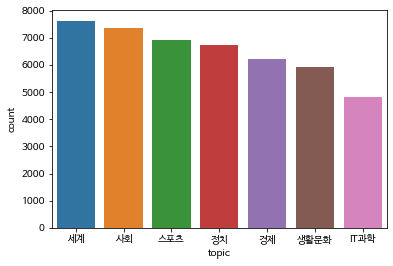

In [33]:
# train2 로 빈도수를 구했지만 test 데이터는 topic이 결측치라 포함되지 않는다.
# order value_counts 기준으로 정렬을 해준다.
sns.countplot(data=df, x='topic', order=df["topic"].value_counts().index)

## 4.문자길이

In [34]:
# apply, lambda를 통해 문자ㅡ 단어 빈도수 파생변수 만들기
# df["len"]
# df["word_count"]
# df["unique_word_count"]
df["len"] = df["title"].apply(lambda x: len(x))
df["word_count"] = df["title"].apply(lambda x: len(x.split()))
df["unique_word_count"] = df["title"].apply(lambda x: len(set(x.split())))
df

,index,title,topic_idx,topic,len,word_count,unique_word_count
0,0,인천 핀란드 항공기 결항 휴가철 여행객 분통,4.0,세계,24,7,7
1,1,실리콘밸리 넘어서겠다 구글 조원 들여 전역 거점화,4.0,세계,27,7,7
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4.0,세계,30,8,8
3,3,nyt 클린턴 측근 기업 특수관계 조명 공과 사 맞물려종합,4.0,세계,32,9,9
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4.0,세계,25,7,7
...,...,...,...,...,...,...,...
54780,54780,인천 오후 시 분 대설주의보 눈 cm 쌓여,NaN,NaN,23,8,8
54781,54781,노래방에서 지인 성추행 외교부 사무관 불구속 입건종합,NaN,NaN,29,7,7
54782,54782,년 전 부마항쟁 부산 시위 사진 점 최초 공개,NaN,NaN,26,9,9
54783,54783,게시판 아리랑tv 아프리카개발은행 총회 개회식 생중계,NaN,NaN,29,6,6


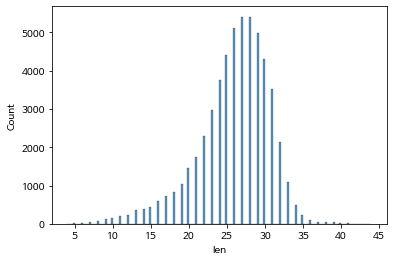

In [35]:
# 서브플롯을 통해 "len", "word_count", "unique_word_count"의 histplot을 시각화 한다
sns.histplot(data=df, x="len")

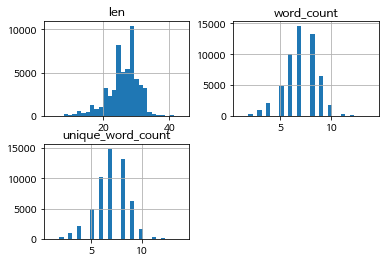

In [38]:
# 확인해본 결과 특별히 눈에 띄는 값은 없음
df[["len", "word_count", "unique_word_count"]].hist(bins=30)
plt.show()

In [39]:
# 통계값을 확인한다.
df[["len", "word_count", "unique_word_count"]].describe()

,len,word_count,unique_word_count
count,54785.000000,54785.000000,54785.000000
mean,25.920599,7.031633,7.000256
std,4.729837,1.561367,1.547073
min,4.000000,1.000000,1.000000
25%,24.000000,6.000000,6.000000
50%,27.000000,7.000000,7.000000
75%,29.000000,8.000000,8.000000
max,44.000000,14.000000,14.000000


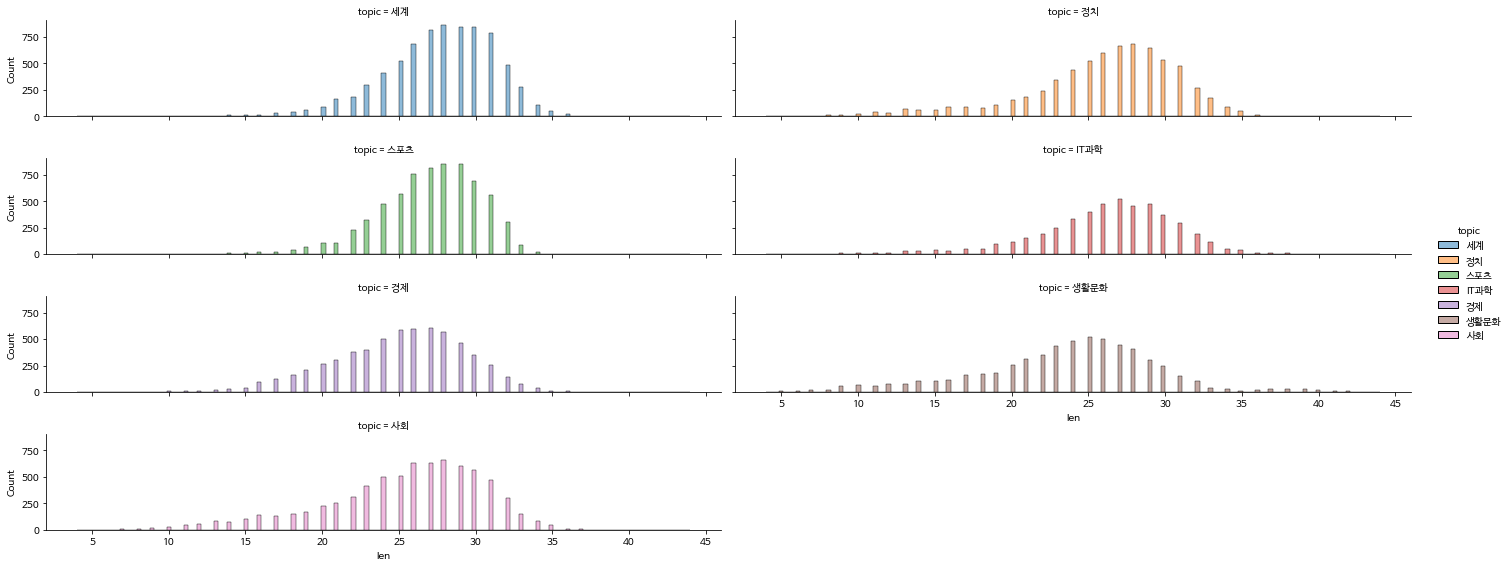

In [48]:
# 문장길이
# displot 으로 topic 별 "len" 의 histplot 시각화 하기
# data=df, x="len", kind="hist", hue="topic", col="topic", col_wrap=2, aspect=5, height=2
sns.displot(data=df, x="len",hue="topic", col="topic", col_wrap=2, aspect=5, height=2)

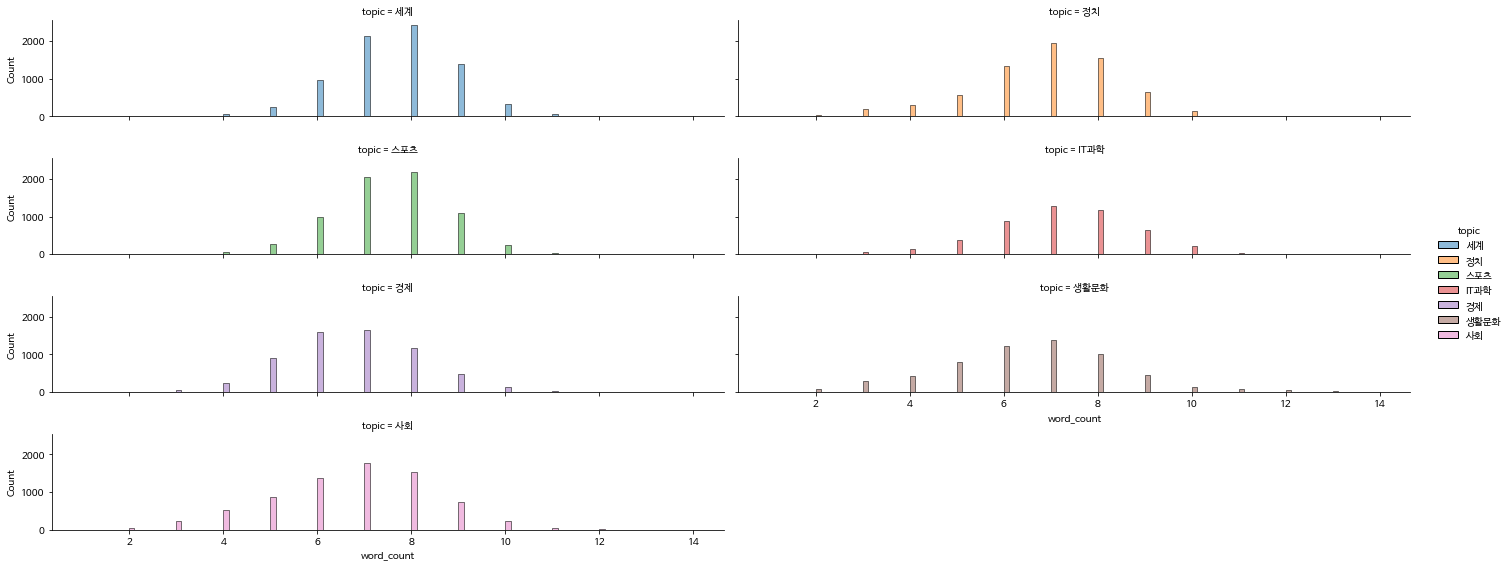

In [49]:
# 단어 수
# displot 으로 topic 별 "word_count"의 histplot 시각화 하기
sns.displot(data=df, x="word_count",hue="topic",col="topic", col_wrap=2, height=2, aspect=5)

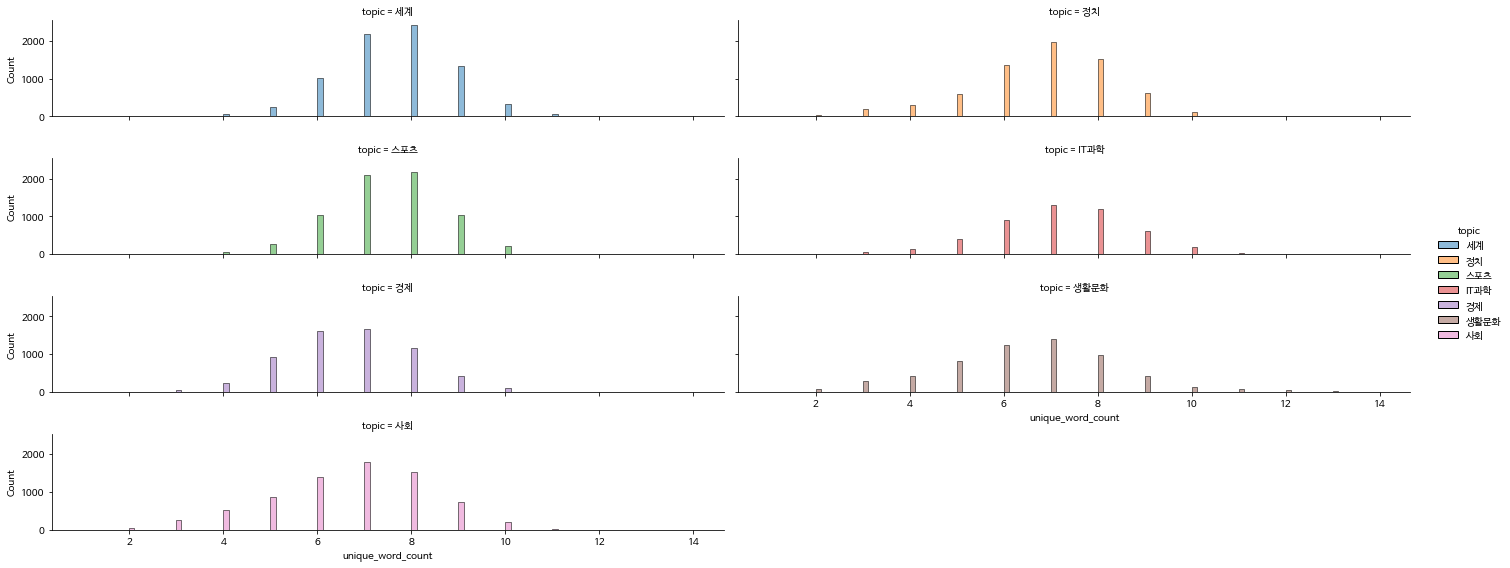

In [50]:
# 중복 제거 단어 수
# displot 으로 topic 별 "unique_word_count" 의 histplot 시각화 하기
sns.displot(data=df, x="unique_word_count", hue="topic", col="topic", col_wrap=2, height=2, aspect=5)

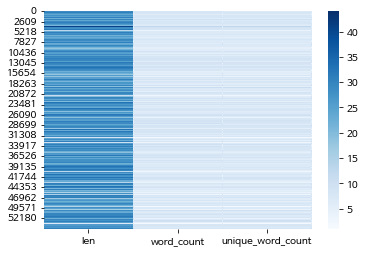

In [53]:
# heatmap을 통한 "len", "word_count", "unique_word_count" 시각화
sns.heatmap(df[["len", "word_count", "unique_word_count"]], cmap="Blues")

## 6.워드클라우드

In [54]:
!pip install wordcloud

In [60]:
from wordcloud import WordCloud

def display_word_cloud(data, width=1200,height=500):
  word_draw = WordCloud(
      font_path="NanumBarunGothic",
      width=width, height=height,
      background_color="white",
      random_state=42
  )
  word_draw.generate(data)

  plt.figure(figsize=(15,7))
  plt.imshow(word_draw)
  plt.axis("off")
  plt.show()

In [56]:
# join()을 이용하여 변수 title 리스트에서 문자열로 변환해 준다.
# content
content = " ".join(df["title"].tolist())
content[:100]

'인천 핀란드 항공기 결항 휴가철 여행객 분통 실리콘밸리 넘어서겠다 구글 조원 들여 전역 거점화 이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것 nyt 클린턴 측근 기업 특수'

In [57]:
len(content)

1474844

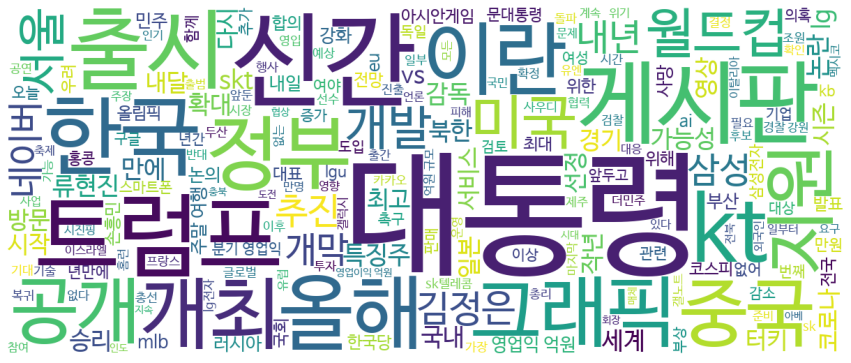

In [61]:
# content를 위해서 만든 함수인 display_word_cloud로 워드클라우드를 시각화 한다.
display_word_cloud(content)

### 특정 토픽만 워드클라우드 시각화

In [63]:
# topic의 unique 값만 보기
df["topic"].unique()

array(['세계', '정치', '스포츠', 'IT과학', '경제', '생활문화', '사회', nan], dtype=object)

In [69]:
# df.loc로 특정 토픽만 가져와서 join으로 문자열을 연결한다.
content = " ".join(df.loc[df["topic"] == "스포츠","title"].tolist())
content[:100]

'박찬호 현진이 승 하니깐 생각이 나는데  고군분투 시즌 서재덕 mvp 덕큐리로 활짝 웃다종합 임도헌 감독 신영석 중심으로 똘똘 뭉쳐 한일전 승리 따냈다 데얀 김치우 out 조영욱 '

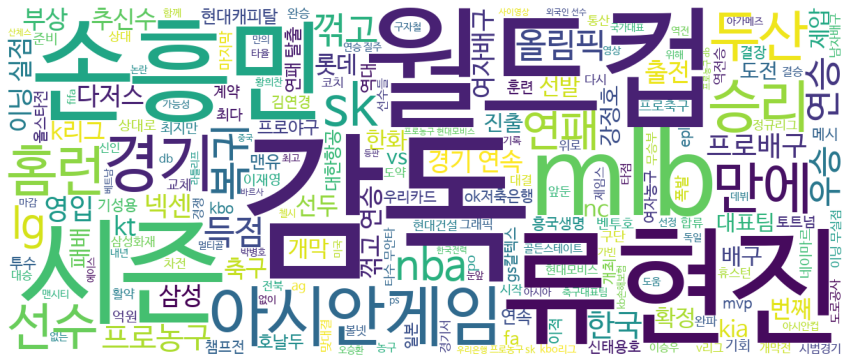

In [70]:
# content를 위해서 만든 함수인 display_word_cloud로 워드클라우드를 시각화 한다.
display_word_cloud(content)

## 5.모델생성(BERT)